# Predicting and Stratifying Crime Hotspots in London Using Spatiotemporal Features (2011–2024)

## Preparation

- [Github link](https://github.com/Geor99e/CASA0006_Assessment.git) 

- Number of words: 1711

- Runtime: Not too long

- Coding environment: See environment_crime_env.yml

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/) (or other license that you like).


## Table of contents

1. [Introduction](#1-Introduction)

1. [Research questions](#2-Research-questions)

1. [Data](#3-Data)

1. [Methodology](#4-Methodology)

1. [Results and discussion](#5-Results-and-discussion)

1. [Conclusion](#6-Conclusion)

1. [Shortcomings and prospects for future work](#7-shortcomings-and-prospects-for-future-work) 

1. [References](#References)

## 1. Introduction

[[ go back to the top ]](#Table-of-contents)

Urban crime exhibits strong spatial and temporal heterogeneity, forming persistent "hotspots" that pose serious challenges to public safety and resource allocation.

With the increasing availability of high-resolution spatial data and advances in machine learning, it becomes possible to predict future crime risks at a micro-geographical level.
This project takes Greater London as a case study, utilizing historical crime density data from 2011 to 2023, structured spatial features (e.g., cluster trends, static risk levels and historical average crime density), and Random Forest classification models to forecast 2024 crime hotspots at the LSOA (Lower Layer Super Output Area) level.

Moreover, instead of a binary hotspot classification, we introduce a four-tier stratification system — low, medium, high, and very high risk — to provide a more nuanced understanding of urban crime risk landscapes. 

This research aims to answer: Can machine learning and spatial methods reliably predict and stratify urban crime hotspots ahead of time, thereby supporting more targeted and equitable urban safety strategies?

## 2. Research questions and Hypothesis

[[ go back to the top ]](#Table-of-contents)

RQ: Is it possible to predict and stratify 2024 crime hotspot levels in London using spatiotemporal crime characteristics at the LSOA scale?

H₀: Crime hotspot levels in 2024 are spatially random and cannot be predicted by historical and structural features.

H₁: Crime hotspot levels in 2024 exhibit spatial structure and can be reliably predicted based on historical density, spatial clustering, and recent crime profiles.

## 3. Data

[[ go back to the top ]](#Table-of-contents)

| Key Data Sources                            | Type         |Description                                                      |
|-------------------------------------|--------------|-------------------------------------------------------------------------|
| Number of crimes (2011-2024)        | Numeric      | Aggregated annually by LSOA, categorized into approximately 30 crime types|
| LSOA Boundary Data                  | Spatial geometries      | Characterizing the spatial geometry of each LSOA in the City of London                                                 |



| Variable                            | Type         | Description                                                             |
|-------------------------------------|--------------|-------------------------------------------------------------------------|
| Total crime density  | Numeric  | Number of crimes per square kilometer per year for each LSOA from 2021 to 2023 (The number of crimes divided by the area)|
| Densities for each crime type  | Numeric  | Disaggregated density per major crime type for 2023|
| Average crime density  | Numeric  | The clustering features are constructed based on the average crime density from 2021 to 2023|
| Crime trends  | Categorical  | Based on the 2021-2023 crime density data, the clustering trend features are constructed|

## 4. Methodology

[[ go back to the top ]](#Table-of-contents)

### 4.1 Data Processing


#### 4.1.1 Geographic boundary data processing

In [1]:
import pandas as pd         # Used to process property tables
import geopandas as gpd
from fiona import listlayers
import os

# Turn off Shapely 2.x's Array API before importing any geometry-related packages
os.environ['SHAPELY_USE_ARRAY_API'] = 'False'

def load_lsoa_gpkg(gpkg_path: str):
    
    # List all layers
    layers = listlayers(gpkg_path)
    print("Found layers:", layers)
    layer = layers[0]  

    # Read the entire layer (with attributes and geometry)
    gdf = gpd.read_file(gpkg_path, layer=layer)
    print(f"Loaded GeoDataFrame: {gdf.shape[0]} rows, {gdf.shape[1]} columns")
    
    # 简单预览
    print("\nThe first 5 rows of the attribute table:")
    print(gdf.head())
    print("\nGeometric type distribution:")
    print(gdf.geometry.geom_type.value_counts())
    
    return gdf

def calculate_lsoa_area(gdf):
    """
    Calculate the area of each LSOA (in square kilometers).
    
    """
    # Confirm the current coordinate system and convert to the appropriate coordinate system for UK area calculations（EPSG:27700 British National Grid）
    print("\nCRS:", gdf.crs)

    if gdf.crs != 'EPSG:27700':
        gdf_projected = gdf.to_crs(epsg=27700)
        print("The coordinate system has been converted to EPSG:27700 for accurate area calculations.")
    else:
        gdf_projected = gdf

    # Calculated area (square meters -> square kilometers)
    gdf_projected['area_km2'] = gdf_projected.geometry.area / 1e6
    print("\nCalculating the area is complete, preview the first 5 lines:")
    print(gdf_projected[['area_km2']].head())

    return gdf_projected[['lsoa21cd','area_km2', 'geometry' ]]  

if __name__ == "__main__":
    gpkg_path = "Data/LSOA.gpkg"
    lsoa_gdf = load_lsoa_gpkg(gpkg_path)
    lsoa_with_area = calculate_lsoa_area(lsoa_gdf) #area



Found layers: ['LSOA']
Loaded GeoDataFrame: 4994 rows, 3 columns

The first 5 rows of the attribute table:
    lsoa21cd                   lsoa21nm  \
0  E01000001        City of London 001A   
1  E01000002        City of London 001B   
2  E01000003        City of London 001C   
3  E01000005        City of London 001E   
4  E01000006  Barking and Dagenham 016A   

                                            geometry  
0  POLYGON ((532151.538 181867.433, 532152.5 1818...  
1  POLYGON ((532634.497 181926.016, 532632.048 18...  
2  POLYGON ((532153.703 182165.155, 532158.25 182...  
3  POLYGON ((533619.062 181402.364, 533639.868 18...  
4  POLYGON ((545126.852 184310.838, 545145.213 18...  

Geometric type distribution:
Polygon         4990
MultiPolygon       4
Name: count, dtype: int64

CRS: EPSG:27700

Calculating the area is complete, preview the first 5 lines:
   area_km2
0  0.129865
1  0.228420
2  0.059054
3  0.189578
4  0.146537


In [2]:
lsoa_with_area.to_file("Data/LSOA_with_area.geojson", driver='GeoJSON')

#### 4.1.2 Crime data processing

In [3]:
# Process the historical crime data 

# 1. Read the original crime CSV file
input_path = 'Data/MPS LSOA Level Crime (Historical).csv'
df = pd.read_csv(input_path)

# 2. Delete the third column (column name 'Borough')
if 'Borough' in df.columns:
    df = df.drop(columns=['Borough'])
else:
    print("Warning: No 'Borough' column found, skip the delete step.")

# 3. Recognize all “year and month” fields (6-digit columns like YYYYYMM)
date_cols = [col for col in df.columns if col.isdigit() and len(col) == 6]

# 4. Sort year and month columns in chronological order
# Convert column name strings to datetime, then sort by datetime
date_cols_sorted = sorted(
    date_cols,
    key=lambda x: pd.to_datetime(x, format='%Y%m')
)

# 5. Fixed first four columns unchanged
static_cols = ['LSOA Code', 'LSOA Name', 'Major Category', 'Minor Category']
missing_statics = [c for c in static_cols if c not in df.columns]
if missing_statics:
    raise KeyError(f"The following required columns were not found：{missing_statics}")

# 6. Rearrangement order: first four columns + time columns
new_order = static_cols + date_cols_sorted
df = df[new_order]

# 7. Preview results
print("First 5 rows after reordering：")
print(df.head())

# 8. Save the results as a new CSV
output_path = 'Data/Crime_data_2010_2023.csv'
df.to_csv(output_path, index=False)


First 5 rows after reordering：
   LSOA Code                  LSOA Name             Major Category  \
0  E01000006  Barking and Dagenham 016A  ARSON AND CRIMINAL DAMAGE   
1  E01000006  Barking and Dagenham 016A  ARSON AND CRIMINAL DAMAGE   
2  E01000006  Barking and Dagenham 016A                   BURGLARY   
3  E01000006  Barking and Dagenham 016A                   BURGLARY   
4  E01000006  Barking and Dagenham 016A              DRUG OFFENCES   

                    Minor Category  201004  201005  201006  201007  201008  \
0                            ARSON       0       0       0       0       0   
1                  CRIMINAL DAMAGE       1       3       0       2       0   
2  BURGLARY BUSINESS AND COMMUNITY       0       0       1       0       0   
3           BURGLARY IN A DWELLING       3       0       0       1       1   
4              POSSESSION OF DRUGS       1       3       0       0       1   

   201009  ...  202206  202207  202208  202209  202210  202211  202212  \
0    

In [4]:
# Process the most recent crime data 

# 1. Read the latest 24 months of crime data CSV
input_path = 'Data/MPS LSOA Level Crime (most recent 24 months).csv'
df = pd.read_csv(input_path)

# 2. Delete the 'Borough' column (if it exists)
if 'Borough' in df.columns:
    df = df.drop(columns=['Borough'])

# 3. Recognize all year-month columns in 'YYYYMM' format
date_cols = [col for col in df.columns if col.isdigit() and len(col) == 6]

# 4. Chronological year-month column
date_cols_sorted = sorted(
    date_cols,
    key=lambda x: pd.to_datetime(x, format='%Y%m')
)

# 5. Make sure the first four static columns exist
static_cols = ['LSOA Code', 'LSOA Name', 'Major Category', 'Minor Category']
missing = [c for c in static_cols if c not in df.columns]
if missing:
    raise KeyError(f"Required column not found:{missing}")

# 6. Rearrangement order: first four columns + sorted year and month columns
new_order = static_cols + date_cols_sorted
df_processed = df[new_order]

# 7. Preview of results
print("Preview of the processed data:")
print(df_processed.head())

# 8. Save as a new CSV file
output_path = 'Data/Crime_data_2023_2025.csv'
df_processed.to_csv(output_path, index=False)



Preview of the processed data:
   LSOA Code                  LSOA Name             Major Category  \
0  E01000006  Barking and Dagenham 016A  ARSON AND CRIMINAL DAMAGE   
1  E01000006  Barking and Dagenham 016A                   BURGLARY   
2  E01000006  Barking and Dagenham 016A                   BURGLARY   
3  E01000006  Barking and Dagenham 016A              DRUG OFFENCES   
4  E01000006  Barking and Dagenham 016A              DRUG OFFENCES   

           Minor Category  202304  202305  202306  202307  202308  202309  \
0         CRIMINAL DAMAGE       1       0       0       2       0       0   
1  BURGLARY - RESIDENTIAL       0       0       0       0       0       0   
2  BURGLARY IN A DWELLING       1       0       0       0       1       0   
3     POSSESSION OF DRUGS       0       0       1       0       2       0   
4    TRAFFICKING OF DRUGS       1       0       1       0       0       0   

   ...  202406  202407  202408  202409  202410  202411  202412  202501  \
0  ...     

In [5]:
# Merge two CSVs of crime data by month, matching the same LSOA Code + Minor Category

def merge_crime_data(file1, file2, output_path):
    
    # 1. Read
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # 2. Defining static columns
    static_cols = ['LSOA Code', 'LSOA Name', 'Major Category', 'Minor Category']

    # 3. Indexed by static columns, merge remaining year and month columns
    df1_idx = df1.set_index(static_cols)
    df2_idx = df2.set_index(static_cols)

    # 4. Horizontal merge, make up 0
    combined = pd.concat([df1_idx, df2_idx], axis=1, sort=True).fillna(0)

    # 5. If there are duplicate year and month columns, retain the first occurrence of the
    combined = combined.loc[:, ~combined.columns.duplicated()]

    # 6. Reset indexes, restore static columns
    combined = combined.reset_index()

    # 7. Rearranging columns: static columns + chronological year-month columns
    month_cols = [c for c in combined.columns if c not in static_cols]
    # Make sure the column names are all strings, then sort by YYYYMM
    month_cols_sorted = sorted(month_cols, key=lambda x: pd.to_datetime(str(x), format='%Y%m'))
    combined = combined[static_cols + month_cols_sorted]

    # 8. Save as a new CSV file
    combined.to_csv(output_path, index=False)
    print(f"The merged file has been saved:{output_path}")

if __name__ == "__main__":
    file1 = 'Data/Crime_data_2010_2023.csv'
    file2 = 'Data/Crime_data_2023_2025.csv'
    output = 'Data/Crime_data_2010_2025.csv'
    merge_crime_data(file1, file2, output)


The merged file has been saved:Data/Crime_data_2010_2025.csv


In [6]:
# Cleaning data

def drop_years(input_csv, years, output_csv):
    
    df = pd.read_csv(input_csv)

    static_cols = ['LSOA Code', 'LSOA Name', 'Major Category', 'Minor Category']

    # Find all the year and month columns and filter out those to delete and those to keep.
    all_month_cols = [c for c in df.columns if c.isdigit() and len(c)==6]
    # Columns to be deleted
    drop_cols = [c for c in all_month_cols if any(c.startswith(year) for year in years)]
    # Columns to be retained
    keep_months = [c for c in all_month_cols if c not in drop_cols]

    # Perform deletion
    df = df.drop(columns=drop_cols)

    # Rearrange
    keep_months_sorted = sorted(keep_months, key=lambda x: pd.to_datetime(x, format='%Y%m'))
    df = df[static_cols + keep_months_sorted]

    df.to_csv(output_csv, index=False)
    print(f"Deleted years {years}, and save the results to:{output_csv}")

if __name__ == "__main__":
    input_csv = 'Data/Crime_data_2010_2025.csv'
    years_to_drop = ['2010', '2025']
    output_csv = 'Data/Crime_data_2011_2024.csv'
    drop_years(input_csv, years_to_drop, output_csv)


Deleted years ['2010', '2025'], and save the results to:Data/Crime_data_2011_2024.csv


In [7]:
# Summarize crime data by month into yearly totals.

import re

def aggregate_to_yearly(input_csv: str,
                        output_csv: str = None) -> pd.DataFrame:
    
    df = pd.read_csv(input_csv)

    static_cols = ['LSOA Code', 'LSOA Name', 'Major Category', 'Minor Category']
    for c in static_cols:
        if c not in df.columns:
            raise KeyError(f"static column {c} Not in the input file.")

    # Find all monthly columns
    month_cols = [c for c in df.columns if re.fullmatch(r'\d{6}', str(c))]
    if not month_cols:
        raise ValueError("No columns in YYYYYMM format were found.")

    # Extract all years and sort
    years = sorted({c[:4] for c in month_cols})

    # For each year, find and sum the corresponding monthly columns
    result = df[static_cols].copy()
    for year in years:
        cols_for_year = [c for c in month_cols if c.startswith(year)]
        # axis=1 row-wise summation
        result[year] = df[cols_for_year].sum(axis=1)
    
    if output_csv:
        result.to_csv(output_csv, index=False)
        print(f"The annual summary results have been saved to:{output_csv}")

    return result

if __name__ == "__main__":
    input_csv = 'Data/Crime_data_2011_2024.csv'
    output_csv = 'Data/Crime_data_2011_2024_yearly.csv'

    df_yearly = aggregate_to_yearly(input_csv, output_csv)


The annual summary results have been saved to:Data/Crime_data_2011_2024_yearly.csv


In [8]:
# Converting data to long data formats

input_path = 'Data/Crime_data_2011_2024_yearly.csv'
df = pd.read_csv(input_path)

# Delete Major Category Column
df = df.drop(columns=['Major Category'], errors='ignore')

year_cols = [col for col in df.columns if col.isdigit() and len(col) == 4]

# Converting wide tables to long tables
df_long = df.melt(
    id_vars=['LSOA Code', 'LSOA Name', 'Minor Category'],
    value_vars=year_cols,
    var_name='Year',
    value_name='Crime_Count'
)

# Rename
df_long = df_long.rename(columns={'Minor Category': 'Crime_Type'})

# Reordering of columns
df_long = df_long[['LSOA Code', 'LSOA Name', 'Year', 'Crime_Type', 'Crime_Count']]

output_path = 'Data/Crime_data_2011_2024_yearly_long.csv'
df_long.to_csv(output_path, index=False)

df_long.head(10)


,LSOA Code,LSOA Name,Year,Crime_Type,Crime_Count
0,E01000006,Barking and Dagenham 016A,2011,ARSON,0.0
1,E01000006,Barking and Dagenham 016A,2011,CRIMINAL DAMAGE,4.0
2,E01000006,Barking and Dagenham 016A,2011,BURGLARY - RESIDENTIAL,0.0
3,E01000006,Barking and Dagenham 016A,2011,BURGLARY BUSINESS AND COMMUNITY,1.0
4,E01000006,Barking and Dagenham 016A,2011,BURGLARY IN A DWELLING,15.0
5,E01000006,Barking and Dagenham 016A,2011,POSSESSION OF DRUGS,9.0
6,E01000006,Barking and Dagenham 016A,2011,TRAFFICKING OF DRUGS,1.0
7,E01000006,Barking and Dagenham 016A,2011,MISC CRIMES AGAINST SOCIETY,0.0
8,E01000006,Barking and Dagenham 016A,2011,POSSESSION OF WEAPONS,0.0
9,E01000006,Barking and Dagenham 016A,2011,OTHER OFFENCES PUBLIC ORDER,0.0


#### 4.1.3 Merging crime data with geographical data

In [9]:
# Load long form crime data
crime_df = pd.read_csv('Data/Crime_data_2011_2024_yearly_long.csv')

# Load LSOA spatial data with area data
lsoa_area_gdf = gpd.read_file('Data/LSOA_with_area.geojson')
lsoa_area_gdf.rename(columns={'lsoa21cd': 'LSOA Code'}, inplace=True)

In [10]:
print("Crime data preview:")
print(crime_df.head())

print("\nLSOA Area data preview:")
print(lsoa_area_gdf.head())

Crime data preview:
   LSOA Code                  LSOA Name  Year  \
0  E01000006  Barking and Dagenham 016A  2011   
1  E01000006  Barking and Dagenham 016A  2011   
2  E01000006  Barking and Dagenham 016A  2011   
3  E01000006  Barking and Dagenham 016A  2011   
4  E01000006  Barking and Dagenham 016A  2011   

                        Crime_Type  Crime_Count  
0                            ARSON          0.0  
1                  CRIMINAL DAMAGE          4.0  
2           BURGLARY - RESIDENTIAL          0.0  
3  BURGLARY BUSINESS AND COMMUNITY          1.0  
4           BURGLARY IN A DWELLING         15.0  

LSOA Area data preview:
   LSOA Code  area_km2                                           geometry
0  E01000001  0.129865  POLYGON ((532151.538 181867.433, 532152.5 1818...
1  E01000002  0.228420  POLYGON ((532634.497 181926.016, 532632.048 18...
2  E01000003  0.059054  POLYGON ((532153.703 182165.155, 532158.25 182...
3  E01000005  0.189578  POLYGON ((533619.062 181402.364, 533639.

Because the crime data does not include City of London, we manually remove the LOSAs under this Borough

In [11]:
# Clarify LSOA codes for City of London
city_of_london_lsoas = ['E01000001', 'E01000002', 'E01000003', 'E01000004', 'E01000005']

# Flagging data availability (excluding City of London)
lsoa_area_gdf['Data_Available'] = ~lsoa_area_gdf['LSOA Code'].isin(city_of_london_lsoas)

# View tagging results
print("Spatial data preview (with data availability markers):")
print(lsoa_area_gdf.head())

Spatial data preview (with data availability markers):
   LSOA Code  area_km2                                           geometry  \
0  E01000001  0.129865  POLYGON ((532151.538 181867.433, 532152.5 1818...   
1  E01000002  0.228420  POLYGON ((532634.497 181926.016, 532632.048 18...   
2  E01000003  0.059054  POLYGON ((532153.703 182165.155, 532158.25 182...   
3  E01000005  0.189578  POLYGON ((533619.062 181402.364, 533639.868 18...   
4  E01000006  0.146537  POLYGON ((545126.852 184310.838, 545145.213 18...   

   Data_Available  
0           False  
1           False  
2           False  
3           False  
4            True  


In [12]:
# Exclusion of City of London from LSOA
valid_lsoas = lsoa_area_gdf[lsoa_area_gdf['Data_Available']]['LSOA Code'].unique()

In [13]:
# Get a list of years and types of crimes
years = crime_df['Year'].unique()
crime_types = crime_df['Crime_Type'].unique()

# Constructing the full data grid (without City of London)
full_grid = pd.MultiIndex.from_product(
    [valid_lsoas, years, crime_types],
    names=['LSOA Code', 'Year', 'Crime_Type']
).to_frame(index=False)

# Previewing Grid Data
print("\nPreview of the complete data grid.")
print(full_grid.head())


Preview of the complete data grid.
   LSOA Code  Year                       Crime_Type
0  E01000006  2011                            ARSON
1  E01000006  2011                  CRIMINAL DAMAGE
2  E01000006  2011           BURGLARY - RESIDENTIAL
3  E01000006  2011  BURGLARY BUSINESS AND COMMUNITY
4  E01000006  2011           BURGLARY IN A DWELLING


In [14]:
# Merged with crime data, no record set to 0
crime_complete_df = pd.merge(
    full_grid,
    crime_df,
    on=['LSOA Code', 'Year', 'Crime_Type'],
    how='left'
).fillna({'Crime_Count': 0})

# Checking the results of consolidated data
print("\nPreview of consolidated crime data:")
print(crime_complete_df.head())



Preview of consolidated crime data:
   LSOA Code  Year                       Crime_Type  \
0  E01000006  2011                            ARSON   
1  E01000006  2011                  CRIMINAL DAMAGE   
2  E01000006  2011           BURGLARY - RESIDENTIAL   
3  E01000006  2011  BURGLARY BUSINESS AND COMMUNITY   
4  E01000006  2011           BURGLARY IN A DWELLING   

                   LSOA Name  Crime_Count  
0  Barking and Dagenham 016A          0.0  
1  Barking and Dagenham 016A          4.0  
2  Barking and Dagenham 016A          0.0  
3  Barking and Dagenham 016A          1.0  
4  Barking and Dagenham 016A         15.0  


In [15]:
# Merge spatial data (select only the columns needed)
final_df = pd.merge(
    crime_complete_df,
    lsoa_area_gdf[['LSOA Code', 'area_km2', 'geometry','Data_Available']],
    on='LSOA Code',
    how='left'
)

# Calculation of crime density
final_df['Crime_Density'] = final_df['Crime_Count'] / final_df['area_km2']

# Checking the final consolidated data results
print("\nPreview of final consolidated data (with crime density):")
print(final_df.head())



Preview of final consolidated data (with crime density):
   LSOA Code  Year                       Crime_Type  \
0  E01000006  2011                            ARSON   
1  E01000006  2011                  CRIMINAL DAMAGE   
2  E01000006  2011           BURGLARY - RESIDENTIAL   
3  E01000006  2011  BURGLARY BUSINESS AND COMMUNITY   
4  E01000006  2011           BURGLARY IN A DWELLING   

                   LSOA Name  Crime_Count  area_km2  \
0  Barking and Dagenham 016A          0.0  0.146537   
1  Barking and Dagenham 016A          4.0  0.146537   
2  Barking and Dagenham 016A          0.0  0.146537   
3  Barking and Dagenham 016A          1.0  0.146537   
4  Barking and Dagenham 016A         15.0  0.146537   

                                            geometry  Data_Available  \
0  POLYGON ((545126.852 184310.838, 545145.213 18...            True   
1  POLYGON ((545126.852 184310.838, 545145.213 18...            True   
2  POLYGON ((545126.852 184310.838, 545145.213 18...            

In [16]:
# Reordering columns to better present data

final_df = final_df[
    ['LSOA Code', 'LSOA Name', 'Year', 'Crime_Type', 'Crime_Count',
     'area_km2', 'Crime_Density', 'geometry', 'Data_Available']
]

print(final_df.head())

   LSOA Code                  LSOA Name  Year  \
0  E01000006  Barking and Dagenham 016A  2011   
1  E01000006  Barking and Dagenham 016A  2011   
2  E01000006  Barking and Dagenham 016A  2011   
3  E01000006  Barking and Dagenham 016A  2011   
4  E01000006  Barking and Dagenham 016A  2011   

                        Crime_Type  Crime_Count  area_km2  Crime_Density  \
0                            ARSON          0.0  0.146537       0.000000   
1                  CRIMINAL DAMAGE          4.0  0.146537      27.296861   
2           BURGLARY - RESIDENTIAL          0.0  0.146537       0.000000   
3  BURGLARY BUSINESS AND COMMUNITY          1.0  0.146537       6.824215   
4           BURGLARY IN A DWELLING         15.0  0.146537     102.363229   

                                            geometry  Data_Available  
0  POLYGON ((545126.852 184310.838, 545145.213 18...            True  
1  POLYGON ((545126.852 184310.838, 545145.213 18...            True  
2  POLYGON ((545126.852 184310.838,

In [17]:
# final_df.to_csv('Data/Final_crime_data.csv')
# This data file is too large !!!

### 4.2 Feature Calculation

#### 4.2.1 Calculation of total crime density 

In [18]:
#  Grouping and aggregating total crimes
total_crime_df = final_df.groupby(['LSOA Code', 'Year']).agg({
    'Crime_Count': 'sum',
    'area_km2': 'first',
    'LSOA Name': 'first',
    'geometry': 'first',
    'Data_Available': 'first'
}).reset_index()

# Calculation of total crime density
total_crime_df['Total_Crime_Density'] = total_crime_df['Crime_Count'] / total_crime_df['area_km2']

# 3. Save as GeoPackage
# import geopandas as gpd
gdf = gpd.GeoDataFrame(total_crime_df, geometry='geometry', crs='EPSG:27700')  
gdf.to_file('Data/LSOA_Total_Crime_Density.gpkg', driver='GPKG')

In [19]:
print(total_crime_df.head())

   LSOA Code  Year  Crime_Count  area_km2                  LSOA Name  \
0  E01000006  2011         96.0  0.146537  Barking and Dagenham 016A   
1  E01000006  2012         94.0  0.146537  Barking and Dagenham 016A   
2  E01000006  2013         93.0  0.146537  Barking and Dagenham 016A   
3  E01000006  2014         73.0  0.146537  Barking and Dagenham 016A   
4  E01000006  2015         82.0  0.146537  Barking and Dagenham 016A   

                                            geometry  Data_Available  \
0  POLYGON ((545126.852 184310.838, 545145.213 18...            True   
1  POLYGON ((545126.852 184310.838, 545145.213 18...            True   
2  POLYGON ((545126.852 184310.838, 545145.213 18...            True   
3  POLYGON ((545126.852 184310.838, 545145.213 18...            True   
4  POLYGON ((545126.852 184310.838, 545145.213 18...            True   

   Total_Crime_Density  
0           655.124663  
1           641.476233  
2           634.652018  
3           498.167713  
4        

#### 4.2.2 Clustering to compute the features of the prediction model (clustered trend features)

In [20]:
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Get a list of years (exclude 2024)
years = sorted(final_df['Year'].unique())
if 2024 in years:
    years.remove(2024)

# Traversing each year for cluster analysis and visualization
for year in years:
    print(f"\n Year being processed:{year}")

    # Filter data for the year
    df_year = final_df[final_df['Year'] == year]

    # Creating a Pivot Table of Crime Types（LSOA × Crime_Type → Crime_Density）
    pivot_df = df_year.pivot_table(index='LSOA Code', 
                                   columns='Crime_Type', 
                                   values='Crime_Density', 
                                   fill_value=0)

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(pivot_df)

    # Clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    pivot_df['Cluster'] = kmeans.fit_predict(X_scaled)

    # Consolidation of spatial information (loading of spatial data on first execution only)
    gdf_year = final_df[final_df['Year'] == year][['LSOA Code', 'geometry']].drop_duplicates()
    merged_gdf = gdf_year.merge(pivot_df[['Cluster']], left_on='LSOA Code', right_index=True)
    merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')

    # Visual Cluster Maps
    # fig, ax = plt.subplots(figsize=(10, 10))
    # merged_gdf.plot(column='Cluster', cmap='Set3', legend=True, edgecolor='black', ax=ax)
    # ax.set_title(f'London LSOA Crime Clusters ({year})')
    # ax.axis('off')
    # plt.tight_layout()
    # plt.show()



 Year being processed:2011

 Year being processed:2012

 Year being processed:2013

 Year being processed:2014

 Year being processed:2015

 Year being processed:2016

 Year being processed:2017

 Year being processed:2018

 Year being processed:2019

 Year being processed:2020

 Year being processed:2021

 Year being processed:2022

 Year being processed:2023


Here I have clustered the crime data for each year, but given the timeliness of the information, using all 13 years of crime data may introduce noise; and using 13 clustering labels will result in elevated feature dimensions, and the model may suffer from overfitting problems and decreased interpretability. So I decided to use the last three years of data to construct the clustered trend features.

In [21]:
# Target year of extraction
target_years = [2021, 2022, 2023]
cluster_results = []

for year in target_years:
    df_year = final_df[final_df['Year'] == year]
    pivot = df_year.pivot_table(index='LSOA Code', columns='Crime_Type', values='Crime_Density', fill_value=0)

    # Standardization + Clustering
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(pivot)
    kmeans = KMeans(n_clusters=5, random_state=42)
    pivot[f'Cluster_{year}'] = kmeans.fit_predict(X_scaled)

    cluster_results.append(pivot[[f'Cluster_{year}']])

# Combining cluster labels across years
cluster_trends_df = pd.concat(cluster_results, axis=1)
cluster_trends_df.reset_index(inplace=True)

# Creating Trend Characteristics Fields
cluster_trends_df['Cluster_Trend'] = cluster_trends_df[
    [f'Cluster_{y}' for y in target_years]
].astype(str).agg('-'.join, axis=1)

# Trend Increasing/Declining/Stable Judgment
cluster_trends_df['Is_Increasing'] = (
    (cluster_trends_df['Cluster_2021'] <= cluster_trends_df['Cluster_2022']) &
    (cluster_trends_df['Cluster_2022'] <= cluster_trends_df['Cluster_2023'])
).astype(int)

cluster_trends_df['Is_Stable'] = (
    (cluster_trends_df['Cluster_2021'] == cluster_trends_df['Cluster_2022']) &
    (cluster_trends_df['Cluster_2022'] == cluster_trends_df['Cluster_2023'])
).astype(int)

cluster_trends_df['Is_Decreasing'] = (
    (cluster_trends_df['Cluster_2021'] >= cluster_trends_df['Cluster_2022']) &
    (cluster_trends_df['Cluster_2022'] >= cluster_trends_df['Cluster_2023']) &
    (cluster_trends_df['Is_Stable'] == 0)
).astype(int)


cluster_trends_df.head()


Crime_Type,LSOA Code,Cluster_2021,Cluster_2022,Cluster_2023,Cluster_Trend,Is_Increasing,Is_Stable,Is_Decreasing
0,E01000006,0,0,4,0-0-4,1,0,0
1,E01000007,1,2,2,1-2-2,1,0,0
2,E01000008,1,0,0,1-0-0,0,0,1
3,E01000009,1,2,2,1-2-2,1,0,0
4,E01000011,1,0,0,1-0-0,0,0,1


#### 4.2.3 Clustering based on average crime density from 2011-2023 as a structural variable

In [22]:
#  Using 2011-2023 data
df_hist = final_df[final_df['Year'].between(2011, 2023)]

#  Calculate average crime density by LSOA + Crime_Type
pivot_avg = df_hist.pivot_table(
    index='LSOA Code',
    columns='Crime_Type',
    values='Crime_Density',
    aggfunc='mean',
    fill_value=0
)

#  Standardized features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot_avg)

#  clustering
kmeans = KMeans(n_clusters=5, random_state=42)
pivot_avg['Cluster_Static'] = kmeans.fit_predict(X_scaled)

#  Reset indexes in preparation for merging with other features
pivot_avg.reset_index(inplace=True)


cluster_Static_df = pivot_avg[['LSOA Code', 'Cluster_Static']]
cluster_Static_df.head()

Crime_Type,LSOA Code,Cluster_Static
0,E01000006,0
1,E01000007,3
2,E01000008,0
3,E01000009,3
4,E01000011,0


#### 4.2.4 The densities of each crime type for each LSOA in 2023 were expanded into a broadsheet format to construct real behavioral profiles

In [23]:
# Screening data for 2023
df_2023 = final_df[final_df['Year'] == 2023]

# Generating a Density-Wide Table for LSOA × Crime_Type
crime_density_2023 = df_2023.pivot_table(
    index='LSOA Code',
    columns='Crime_Type',
    values='Crime_Density',
    fill_value=0
)

crime_density_2023.columns = [f"2023_Crime_Density_{col}" for col in crime_density_2023.columns]
crime_density_2023.reset_index(inplace=True)

crime_density_2023.head()


,LSOA Code,2023_Crime_Density_AGGRAVATED VEHICLE TAKING,2023_Crime_Density_ARSON,2023_Crime_Density_BICYCLE THEFT,2023_Crime_Density_BURGLARY - RESIDENTIAL,2023_Crime_Density_BURGLARY BUSINESS AND COMMUNITY,2023_Crime_Density_BURGLARY IN A DWELLING,2023_Crime_Density_BURGLARY NON-DWELLING,2023_Crime_Density_CRIMINAL DAMAGE,2023_Crime_Density_HOMICIDE,...,2023_Crime_Density_ROBBERY OF BUSINESS PROPERTY,2023_Crime_Density_ROBBERY OF PERSONAL PROPERTY,2023_Crime_Density_SHOPLIFTING,2023_Crime_Density_THEFT FROM A VEHICLE,2023_Crime_Density_THEFT FROM THE PERSON,2023_Crime_Density_THEFT OR UNAUTH TAKING OF A MOTOR VEH,2023_Crime_Density_TRAFFICKING OF DRUGS,2023_Crime_Density_VIOLENCE WITH INJURY,2023_Crime_Density_VIOLENCE WITHOUT INJURY,2023_Crime_Density_VIOLENT DISORDER
0,E01000006,0.0,0.000000,0.000000,0.0,0.000000,20.472646,0.0,34.121076,0.0,...,0.000000,13.648430,0.000000,40.945291,13.648430,47.769507,13.648430,40.945291,211.550673,0.0
1,E01000007,0.0,4.997651,44.978862,0.0,19.990605,94.955374,0.0,179.915446,0.0,...,0.000000,194.908400,19.990605,84.960072,389.816800,19.990605,24.988256,324.847334,629.704062,0.0
2,E01000008,0.0,0.000000,0.000000,0.0,9.220780,50.714289,0.0,110.649358,0.0,...,0.000000,46.103899,36.883119,87.597409,23.051950,106.038968,18.441560,82.987019,179.805207,0.0
3,E01000009,0.0,0.000000,15.629893,0.0,15.629893,101.594306,0.0,226.633451,0.0,...,7.814947,203.188612,31.259786,93.779359,171.928825,54.704626,62.519573,304.782917,523.601422,0.0
4,E01000011,0.0,0.000000,0.000000,0.0,0.000000,54.565923,0.0,21.826369,0.0,...,0.000000,65.479107,0.000000,65.479107,10.913185,65.479107,0.000000,185.524138,556.572413,0.0


#### 4.2.5 Consolidation of data

In [24]:
# First merge trend features with structural clustering
merged_df = pd.merge(cluster_trends_df, cluster_Static_df, on='LSOA Code', how='left')

# Reconsolidation 2023 Crime Density Characterization
final_features_df = pd.merge(merged_df, crime_density_2023, on='LSOA Code', how='left')

final_features_df.head()

,LSOA Code,Cluster_2021,Cluster_2022,Cluster_2023,Cluster_Trend,Is_Increasing,Is_Stable,Is_Decreasing,Cluster_Static,2023_Crime_Density_AGGRAVATED VEHICLE TAKING,...,2023_Crime_Density_ROBBERY OF BUSINESS PROPERTY,2023_Crime_Density_ROBBERY OF PERSONAL PROPERTY,2023_Crime_Density_SHOPLIFTING,2023_Crime_Density_THEFT FROM A VEHICLE,2023_Crime_Density_THEFT FROM THE PERSON,2023_Crime_Density_THEFT OR UNAUTH TAKING OF A MOTOR VEH,2023_Crime_Density_TRAFFICKING OF DRUGS,2023_Crime_Density_VIOLENCE WITH INJURY,2023_Crime_Density_VIOLENCE WITHOUT INJURY,2023_Crime_Density_VIOLENT DISORDER
0,E01000006,0,0,4,0-0-4,1,0,0,0,0.0,...,0.000000,13.648430,0.000000,40.945291,13.648430,47.769507,13.648430,40.945291,211.550673,0.0
1,E01000007,1,2,2,1-2-2,1,0,0,3,0.0,...,0.000000,194.908400,19.990605,84.960072,389.816800,19.990605,24.988256,324.847334,629.704062,0.0
2,E01000008,1,0,0,1-0-0,0,0,1,0,0.0,...,0.000000,46.103899,36.883119,87.597409,23.051950,106.038968,18.441560,82.987019,179.805207,0.0
3,E01000009,1,2,2,1-2-2,1,0,0,3,0.0,...,7.814947,203.188612,31.259786,93.779359,171.928825,54.704626,62.519573,304.782917,523.601422,0.0
4,E01000011,1,0,0,1-0-0,0,0,1,0,0.0,...,0.000000,65.479107,0.000000,65.479107,10.913185,65.479107,0.000000,185.524138,556.572413,0.0


#### 4.2.6 Constructing predictive labels (binary classification)
We first take a binary approach and define an LSOA as a hotspot if its total crime density in 2024 is higher than the city's 75% quartile (Top 25%), that is
is_hotspot_2024 = 1 if total crime density ≥ 75% quartile else 0

In [25]:
# Extraction of data for 2024
df_2024 = final_df[final_df['Year'] == 2024]

# Calculate the total crime density for each LSOA
lsoa_total_2024 = df_2024.groupby('LSOA Code').agg({
    'Crime_Count': 'sum',
    'area_km2': 'first'
}).reset_index()

# Calculation of total crime density
lsoa_total_2024['Total_Crime_Density_2024'] = lsoa_total_2024['Crime_Count'] / lsoa_total_2024['area_km2']

# Setting hot spot thresholds (Top 25%)
threshold = lsoa_total_2024['Total_Crime_Density_2024'].quantile(0.75)

# Creating Hot Tags
lsoa_total_2024['is_hotspot_2024'] = (lsoa_total_2024['Total_Crime_Density_2024'] >= threshold).astype(int)

# Final labeling data
labels_2024 = lsoa_total_2024[['LSOA Code', 'Total_Crime_Density_2024', 'is_hotspot_2024']]

labels_2024.head()


,LSOA Code,Total_Crime_Density_2024,is_hotspot_2024
0,E01000006,607.355157,0
1,E01000007,2603.776320,1
2,E01000008,622.402640,0
3,E01000009,1899.032024,1
4,E01000011,1255.016224,1


In [26]:
final_model_data = final_features_df.merge(labels_2024, on='LSOA Code', how='left')

final_model_data.head()

,LSOA Code,Cluster_2021,Cluster_2022,Cluster_2023,Cluster_Trend,Is_Increasing,Is_Stable,Is_Decreasing,Cluster_Static,2023_Crime_Density_AGGRAVATED VEHICLE TAKING,...,2023_Crime_Density_SHOPLIFTING,2023_Crime_Density_THEFT FROM A VEHICLE,2023_Crime_Density_THEFT FROM THE PERSON,2023_Crime_Density_THEFT OR UNAUTH TAKING OF A MOTOR VEH,2023_Crime_Density_TRAFFICKING OF DRUGS,2023_Crime_Density_VIOLENCE WITH INJURY,2023_Crime_Density_VIOLENCE WITHOUT INJURY,2023_Crime_Density_VIOLENT DISORDER,Total_Crime_Density_2024,is_hotspot_2024
0,E01000006,0,0,4,0-0-4,1,0,0,0,0.0,...,0.000000,40.945291,13.648430,47.769507,13.648430,40.945291,211.550673,0.0,607.355157,0
1,E01000007,1,2,2,1-2-2,1,0,0,3,0.0,...,19.990605,84.960072,389.816800,19.990605,24.988256,324.847334,629.704062,0.0,2603.776320,1
2,E01000008,1,0,0,1-0-0,0,0,1,0,0.0,...,36.883119,87.597409,23.051950,106.038968,18.441560,82.987019,179.805207,0.0,622.402640,0
3,E01000009,1,2,2,1-2-2,1,0,0,3,0.0,...,31.259786,93.779359,171.928825,54.704626,62.519573,304.782917,523.601422,0.0,1899.032024,1
4,E01000011,1,0,0,1-0-0,0,0,1,0,0.0,...,0.000000,65.479107,10.913185,65.479107,0.000000,185.524138,556.572413,0.0,1255.016224,1


#### 4.2.7 Total Crime Density Time Series Features
Add the total crime density time series for each LSOA for the years 2011-2023 as an input feature (again, we only select data for 2021-2023)

In [27]:
# Pivot to wide table (one column per year)
density_time_series = total_crime_df.pivot(
    index='LSOA Code',
    columns='Year',
    values='Total_Crime_Density'
).add_prefix('Total_Density_').reset_index()

density_time_series = density_time_series[
    ['LSOA Code', 'Total_Density_2021', 'Total_Density_2022', 'Total_Density_2023']
]

density_time_series['density_avg_3yr'] = density_time_series[[f'Total_Density_{y}' for y in [2021, 2022, 2023]]].mean(axis=1)
density_time_series['density_change_3yr'] = density_time_series['Total_Density_2023'] - density_time_series['Total_Density_2021']


In [28]:
final_model_data2 = final_model_data.merge(density_time_series,on='LSOA Code', how='left')

final_model_data2.head()

,LSOA Code,Cluster_2021,Cluster_2022,Cluster_2023,Cluster_Trend,Is_Increasing,Is_Stable,Is_Decreasing,Cluster_Static,2023_Crime_Density_AGGRAVATED VEHICLE TAKING,...,2023_Crime_Density_VIOLENCE WITH INJURY,2023_Crime_Density_VIOLENCE WITHOUT INJURY,2023_Crime_Density_VIOLENT DISORDER,Total_Crime_Density_2024,is_hotspot_2024,Total_Density_2021,Total_Density_2022,Total_Density_2023,density_avg_3yr,density_change_3yr
0,E01000006,0,0,4,0-0-4,1,0,0,0,0.0,...,40.945291,211.550673,0.0,607.355157,0,641.476233,812.081614,593.706726,682.421524,-47.769507
1,E01000007,1,2,2,1-2-2,1,0,0,3,0.0,...,324.847334,629.704062,0.0,2603.776320,1,2533.809202,2363.889058,3233.480382,2710.392881,699.671180
2,E01000008,1,0,0,1-0-0,0,0,1,0,0.0,...,82.987019,179.805207,0.0,622.402640,0,1032.727343,968.181884,1078.831242,1026.580156,46.103899
3,E01000009,1,2,2,1-2-2,1,0,0,3,0.0,...,304.782917,523.601422,0.0,1899.032024,1,2328.854086,2297.594300,2946.234868,2524.227751,617.380781
4,E01000011,1,0,0,1-0-0,0,0,1,0,0.0,...,185.524138,556.572413,0.0,1255.016224,1,1211.363486,1124.058010,1320.495332,1218.638943,109.131846


In [29]:
final_model_data2.to_csv('Data/Final_model_data.csv')

Considering that in real urban space, crime density is not simply “hot/not hot”, but varies continuously. I decided to categorize it into 4 classes as shown in the table below:
| Class | Quartile Range | Description |
|-------------------------------------|--------------|-------------------------------------------------------------------------|
| 0 | 0-50% | Non-hot spots (low risk area) |
| 1 | 50%-75% | Medium hotspot (medium risk zone) |
| 2 | 75%-90% | High Hot Spot (High Risk Zone)
| 3 | 90%-100% | Very High Hot Spot (Very High Risk Zone) | | 3 | 90%-100% | Extremely High Hot Spot (Very High Risk Zone)

In [30]:
Multi_cat = pd.read_csv("Data/Final_model_data.csv")

# Calculation of quartiles
q50 = Multi_cat['Total_Crime_Density_2024'].quantile(0.5)
q75 = Multi_cat['Total_Crime_Density_2024'].quantile(0.75)
q90 = Multi_cat['Total_Crime_Density_2024'].quantile(0.9)

# Defining Grouping Functions
def categorize_density(x):
    if x <= q50:
        return 0  # Non-hot (low)
    elif x <= q75:
        return 1  # Medium hotspot
    elif x <= q90:
        return 2  # High hot spot
    else:
        return 3  # Very High Hot Spot


Multi_cat['hotspot_level'] = Multi_cat['Total_Crime_Density_2024'].apply(categorize_density)

Multi_cat.head()

,Unnamed: 0,LSOA Code,Cluster_2021,Cluster_2022,Cluster_2023,Cluster_Trend,Is_Increasing,Is_Stable,Is_Decreasing,Cluster_Static,...,2023_Crime_Density_VIOLENCE WITHOUT INJURY,2023_Crime_Density_VIOLENT DISORDER,Total_Crime_Density_2024,is_hotspot_2024,Total_Density_2021,Total_Density_2022,Total_Density_2023,density_avg_3yr,density_change_3yr,hotspot_level
0,0,E01000006,0,0,4,0-0-4,1,0,0,0,...,211.550673,0.0,607.355157,0,641.476233,812.081614,593.706726,682.421524,-47.769507,1
1,1,E01000007,1,2,2,1-2-2,1,0,0,3,...,629.704062,0.0,2603.776320,1,2533.809202,2363.889058,3233.480382,2710.392881,699.671180,3
2,2,E01000008,1,0,0,1-0-0,0,0,1,0,...,179.805207,0.0,622.402640,0,1032.727343,968.181884,1078.831242,1026.580156,46.103899,1
3,3,E01000009,1,2,2,1-2-2,1,0,0,3,...,523.601422,0.0,1899.032024,1,2328.854086,2297.594300,2946.234868,2524.227751,617.380781,2
4,4,E01000011,1,0,0,1-0-0,0,0,1,0,...,556.572413,0.0,1255.016224,1,1211.363486,1124.058010,1320.495332,1218.638943,109.131846,2


### 4.3 Building predictive models

#### 4.3.1 Binary Classification 

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [34]:
binary_class = pd.read_csv("Data/Final_model_data.csv")

# Define the columns to be excluded
exclude_cols_b = ['Unnamed: 0', 'LSOA Code', 'Cluster_Trend', 'is_hotspot_2024','Total_Crime_Density_2024']
feature_cols_b = [col for col in binary_class.columns if col not in exclude_cols_b]

# Constructing training sets
X_b = binary_class[feature_cols_b]
y_b = binary_class['is_hotspot_2024']

# Splitting the training and test sets
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

# Build and train the model
model_b = RandomForestClassifier(n_estimators=100, random_state=42)
model_b.fit(X_b_train, y_b_train)

# model prediction
y_b_pred = model_b.predict(X_b_test)

# Evaluation reports
report_b = classification_report(y_b_test, y_b_pred, output_dict=True)
report_b_df = pd.DataFrame(report_b).transpose()




### 4.3.2 Multilevel Classification

In [35]:
# Feature Preparation
exclude_cols_m = ['Unnamed: 0', 'LSOA Code', 'Cluster_Trend', 'is_hotspot_2024', 'Total_Crime_Density_2024', 'hotspot_level']
feature_cols_m = [col for col in Multi_cat.columns if col not in exclude_cols_m]

X_m = Multi_cat[feature_cols_m]
y_m = Multi_cat['hotspot_level']

# Divide training set/test set
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_m, y_m, test_size=0.2, random_state=42)

# Training Multi-Classification Models
model_multi = RandomForestClassifier(n_estimators=100, random_state=42)
model_multi.fit(X_m_train, y_m_train)

# Forecasting and assessment
y_m_pred = model_multi.predict(X_m_test)
report_multi = pd.DataFrame(classification_report(y_m_test, y_m_pred, output_dict=True)).transpose()



## 5. Results and discussion

[[ go back to the top ]](#Table-of-contents)

### 5.1 Model Report Analysis

In [36]:
report_b_df

,precision,recall,f1-score,support
0,0.971204,0.966146,0.968668,768.000000
1,0.888889,0.904348,0.896552,230.000000
accuracy,0.951904,0.951904,0.951904,0.951904
macro avg,0.930047,0.935247,0.932610,998.000000
weighted avg,0.952234,0.951904,0.952048,998.000000


In [37]:
report_multi

,precision,recall,f1-score,support
0,0.940039,0.920455,0.930144,528.000000
1,0.745020,0.779167,0.761711,240.000000
2,0.698630,0.750000,0.723404,136.000000
3,0.857143,0.765957,0.808989,94.000000
accuracy,0.848697,0.848697,0.848697,0.848697
macro avg,0.810208,0.803895,0.806062,998.000000
weighted avg,0.852435,0.848697,0.850054,998.000000


Compared to a binary hotspot classification achieving 95.2% weighted F1-score, the multi-class prediction model achieves an 85.0% weighted F1-score across four risk levels. Although multi-class classification exhibits naturally lower performance, it provides finer granularity in hotspot stratification, enabling more targeted crime prevention strategies based on the severity of risk.

### 5.2 Confusion matrix analysis

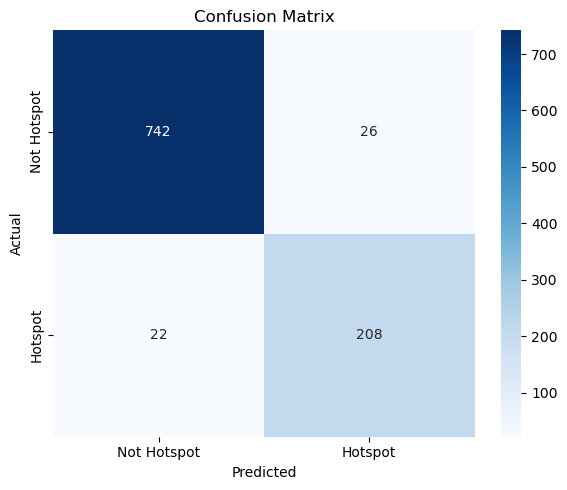

In [ ]:
# Confusion Matrix Visualization (Binary Classfication)
conf_matrix = confusion_matrix(y_b_test, y_b_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hotspot', 'Hotspot'], yticklabels=['Not Hotspot', 'Hotspot'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

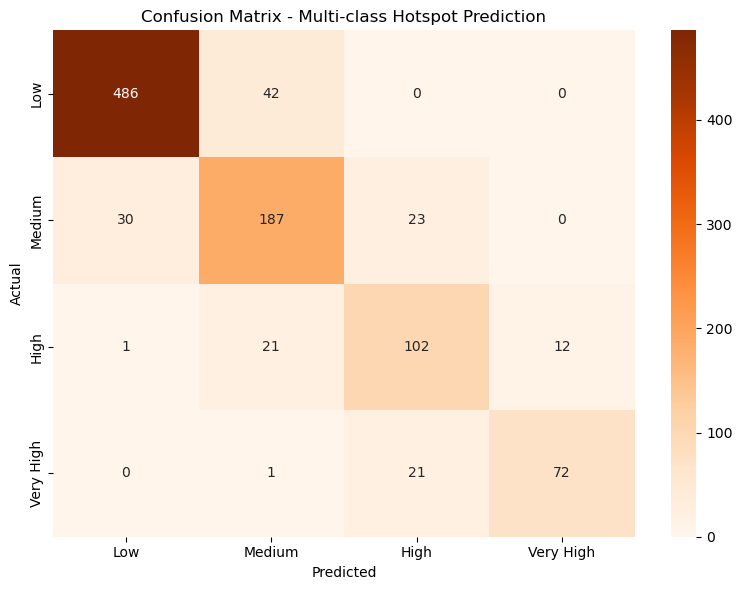

In [ ]:
# Confusion Matrix Visualization (Multiclassification)
conf_matrix = confusion_matrix(y_m_test, y_m_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=['Low', 'Medium', 'High', 'Very High'], yticklabels=['Low', 'Medium', 'High', 'Very High'])
plt.title("Confusion Matrix - Multi-class Hotspot Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

From the confusion matrix of the binary classification, the model has a very high classification accuracy (~95%); there is a small amount of hotspot and non-hotspot confusion (~2.5%-3% misclassification rate); and the classification boundaries are clear. For multiclassification, classification is significantly more difficult, especially the transition between medium and high risk levels; there are neighboring class confusions, but no serious cross-class errors (e.g., Very High is predicted to be Low); and the overall accuracy is about 85%, which is in line with the expectations of multiclassification routines.

### 5.3 Feature importance analysis

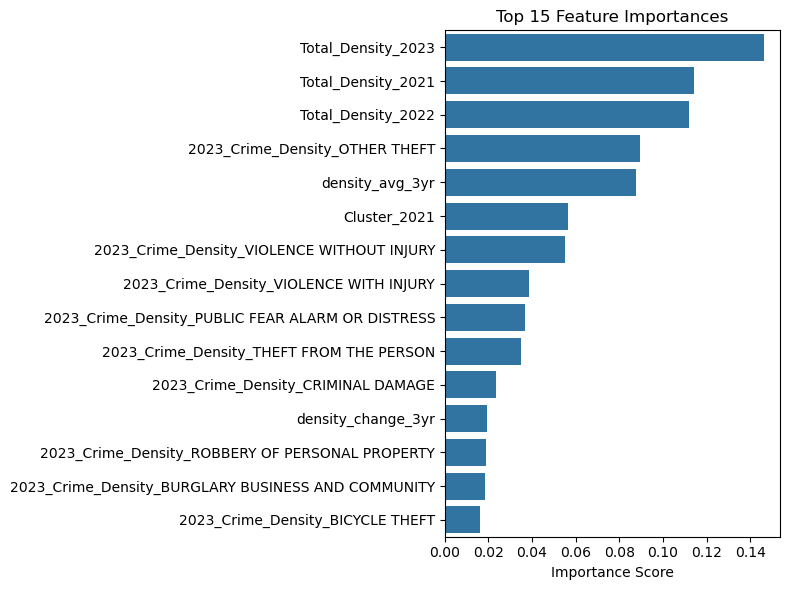

In [46]:
# Feature Importance Visualization (Binary Classfication)
importances = model_b.feature_importances_
indices = np.argsort(importances)[::-1][:15]
top_features = [feature_cols_b[i] for i in indices]

plt.figure(figsize=(8, 6))
sns.barplot(x=importances[indices], y=top_features)
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

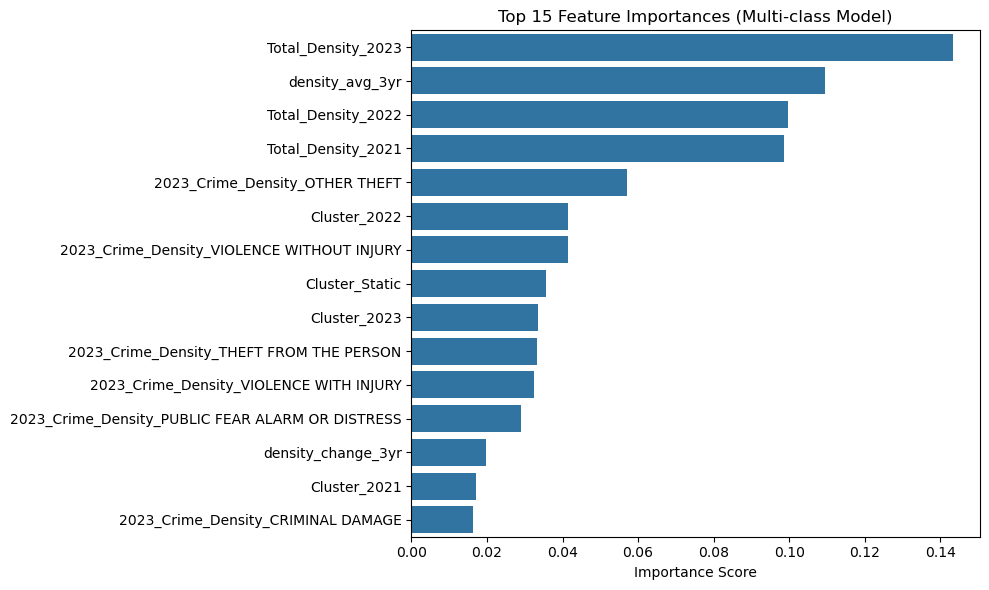

In [ ]:
# Feature Importance Visualization (Multiclassification)
importances = model_multi.feature_importances_
indices = np.argsort(importances)[::-1][:15]
top_features = [X_m_train.columns[i] for i in indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=top_features)
plt.title("Top 15 Feature Importances (Multi-class Model)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In both models, total crime density (Total_Density_2023/2022/2021) is the most important feature. total_density_2023 is the most central driver, suggesting that the current level of density is critical to the prediction of future risk, whether it is simply split into hotspots/non-hotspots or broken down into four tiers. The most important driver is the current level of density.

In terms of discrepancies：

| Perspective                            | Binary classification         |Multiclassification                                       |
|-----------------------------------|--------------|-------------------------------------------------------------------------|
| Impact of clustering features     | Only Cluster_2021 (earlier year) is retained| Cluster_2022, Cluster_Static, Cluster_2023 appear|
| Impact of specific crime types    | More occurrences of secondary types such as BURGLARY, BICYCLE THEFT      | Mainly OTHER THEFT, VIOLENCE WITHOUT INJURY |
| Importance of trend characteristics    | Small weighting of trends in the disaggregation| density_change_3yr Moderately important|

The Multiclassification model relies more on spatial clustering structure and overall trend changes; the binary classification model places more emphasis on current crime intensity (especially in 2023) and relies less on historical trajectories and spatial patterns; and the multiclassification model requires a more complex synthesis of judgments (trends, spatial structure, and mixing of types), whereas the binary classification is more of a one-time decision.

### 5.4 ROC curve analysis

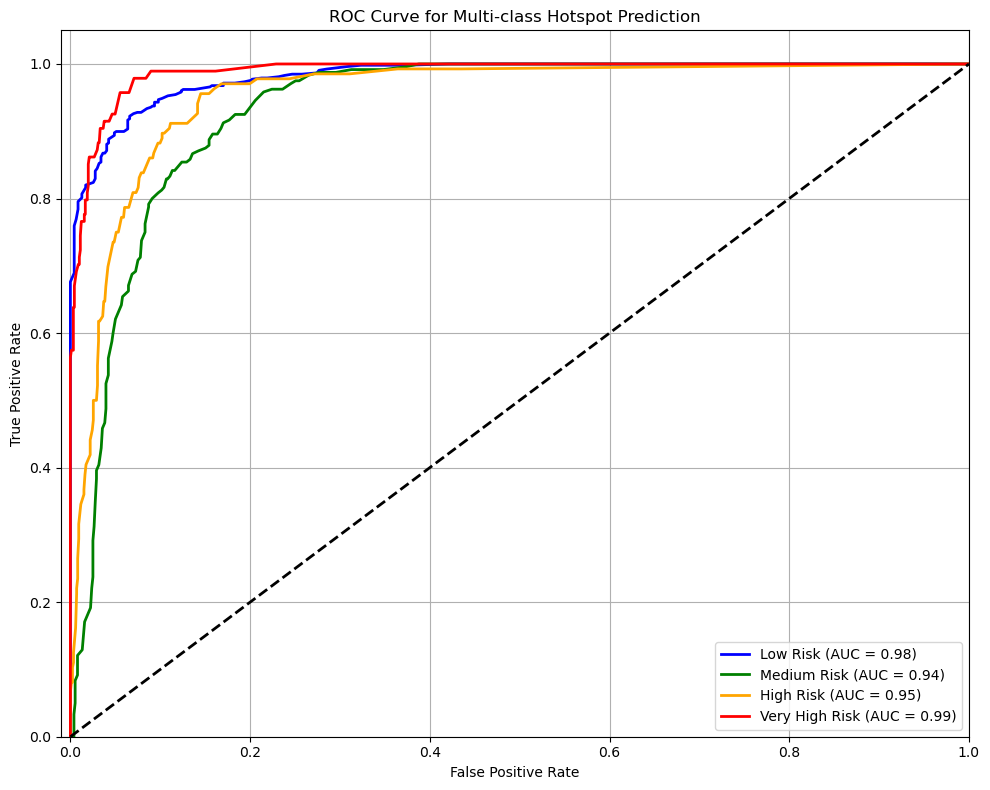

In [47]:
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


# Plotting multi-category ROC curves
# Need to binarize labels for multiple classifications
classes = [0, 1, 2, 3]
y_test_bin = label_binarize(y_m_test, classes=classes)
y_score = model_multi.predict_proba(X_m_test)

# Category-by-category mapping
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']
labels = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']

for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Hotspot Prediction')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Very High Risk (red): almost immediately in the upper left corner, with an AUC of 0.99, indicating that the Very High Risk LSOA is very clearly distinguished from the other categories. This is logical, as very high hotspots tend to be very dense and well characterized.

High Risk (orange) and Medium Risk (green): AUC 0.95 and 0.94, respectively, suggesting that the Medium and High Risk areas are also well differentiated. The curves are slightly lower than Very High Risk, and there may be some crossover (e.g., Medium-High Risk areas are adjacent and have overlapping features).

Low Risk (blue):
AUC 0.98, the ability to predict low risk areas is very good, indicating that the model is very reliable in distinguishing “safe and stable areas”.

### 5.5 Visualization of predicted results

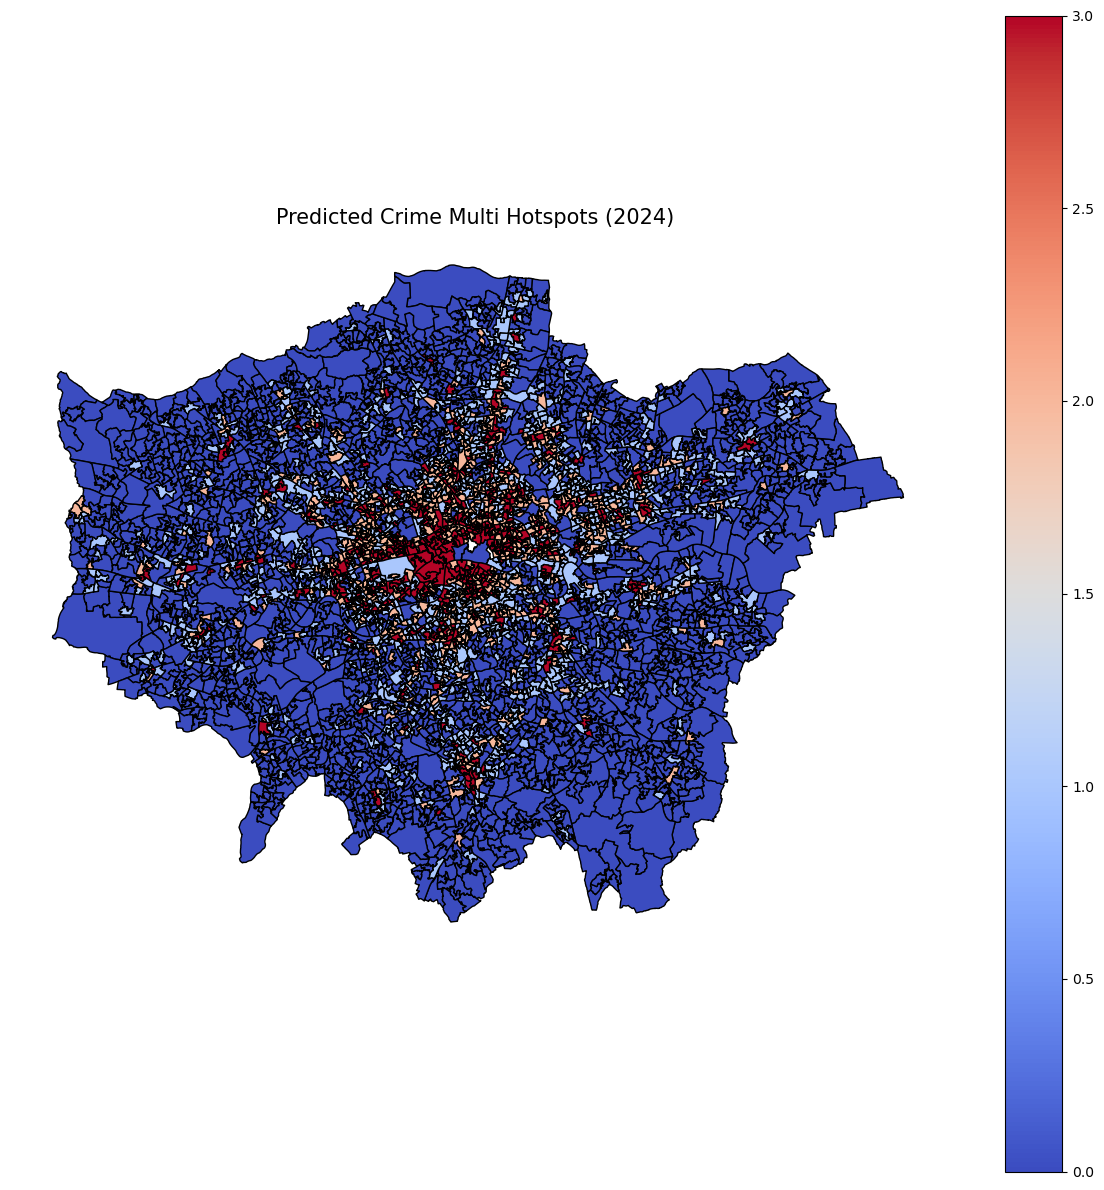

In [50]:
# Refit complete data and predict
model_multi.fit(X_m, y_m)
Multi_cat['predicted_hotspot'] = model_multi.predict(X_m)

# Loading geographic boundary files
gdf = gpd.read_file("Data/LSOA_with_area.geojson")  

# Merging predicted values into spatial data
Crime_multi_hotspot_2024 = gdf.merge(Multi_cat[['LSOA Code', 'predicted_hotspot']], left_on='lsoa21cd', right_on='LSOA Code', how='left')

# Visualization of predictive hotspot maps
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))
Crime_multi_hotspot_2024.plot(column='predicted_hotspot', cmap='coolwarm', legend=True, edgecolor='black', ax=ax)
ax.set_title("Predicted Crime Multi Hotspots (2024) ", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

# Save predictions as CSV
# csv_output_path = "Data/LSOA_Predicted_Hotspots_2024.csv"
# Multi_cat[['LSOA Code', 'predicted_hotspot']].to_csv(csv_output_path, index=False)


The spatial distribution of predicted crime risk levels shows a typical core-periphery pattern. Large zones of very high and high risk are concentrated in central London, reflecting areas of intense commercial activity, transportation hubs and high population movement. Medium-risk zones form transitional buffers around these cores, while low-risk zones are concentrated in suburban and peripheral areas. This stratification pattern is consistent with known theories of urban criminology and provides strong validation of the model's predictive credibility.

In our previous work we projected the spatial distribution of overall crime density, in order to take into account different crime types and more complex crime hotspots. Taking theft and violent crime as examples, I categorize the 2024 densities of the two typical crime types of “theft” and “violence” into three levels of “low/medium/high” and map their combinations into nine 3×3 categories to portray different crime hotspots. The combination of the two is mapped into nine 3×3 categories to portray different degrees of composite hotspots.

=== Classification Report ===
              precision    recall  f1-score   support

         0_0     0.8128    0.9271    0.8662       384
         0_1     0.4167    0.3333    0.3704        90
         0_2     1.0000    0.0800    0.1481        25
         1_0     0.3889    0.2386    0.2958        88
         1_1     0.3525    0.4479    0.3945        96
         1_2     0.4265    0.4462    0.4361        65
         2_0     0.5000    0.0741    0.1290        27
         2_1     0.4500    0.4286    0.4390        63
         2_2     0.7303    0.8125    0.7692       160

    accuracy                         0.6413       998
   macro avg     0.5642    0.4209    0.4276       998
weighted avg     0.6304    0.6413    0.6173       998

=== Confusion Matrix ===
[[356  12   0  10   6   0   0   0   0]
 [ 34  30   0   5  19   1   0   1   0]
 [  1   7   2   0   8   6   0   0   1]
 [ 38   7   0  21  17   3   0   2   0]
 [  8  11   0   5  43  14   1   6   8]
 [  0   4   0   0  12  29   1   1  18]
 [  1 

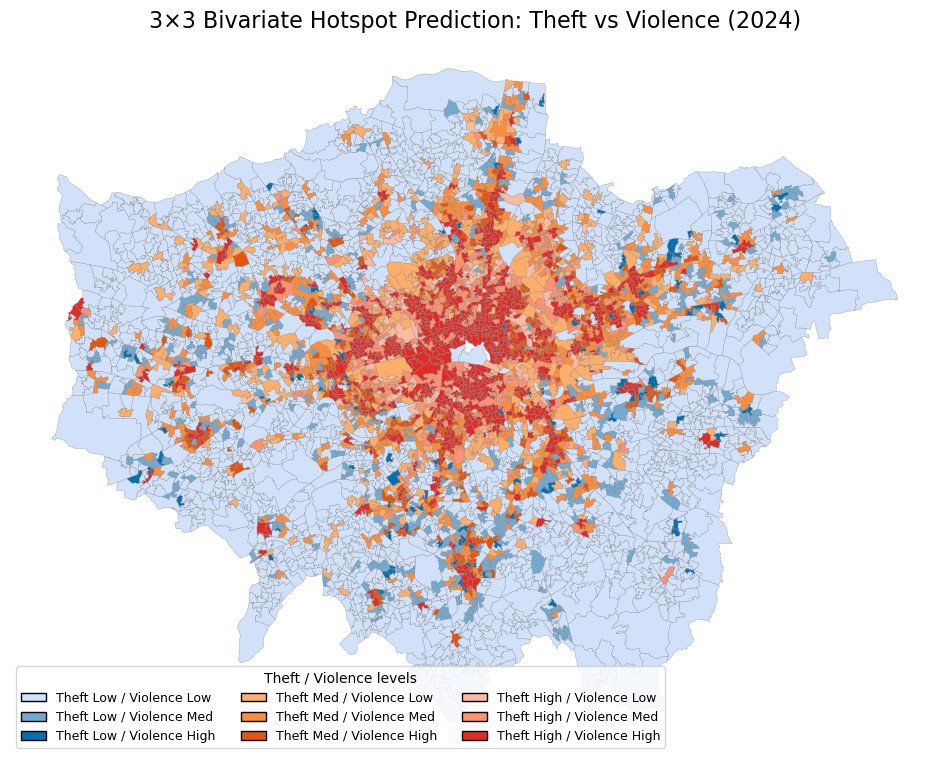

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Constructing Bivariate 3×3 Labels

types = ["VIOLENCE WITH INJURY", "THEFT FROM THE PERSON"]
df24 = final_df[final_df["Year"] == 2024]
df24 = df24[df24["Crime_Type"].isin(types)]

# Pivot the two crime densities to a wide table: column LSOA×2
df_wide = df24.pivot(
    index="LSOA Code",
    columns="Crime_Type",
    values="Crime_Density"
).rename(columns={
    "VIOLENCE WITH INJURY": "D_VIOLENCE",
    "THEFT FROM THE PERSON": "D_THEFT"
}).reset_index()

# Calculate the 50%/75% quantile threshold for each type and grade 0/1/2
cuts = {}
for col in ["D_VIOLENCE", "D_THEFT"]:
    q50 = df_wide[col].quantile(0.5)
    q75 = df_wide[col].quantile(0.75)
    cuts[col] = (q50, q75)
    df_wide[col+"_lvl"] = df_wide[col].apply(
        lambda x: 0 if x<=q50 else (1 if x<=q75 else 2)
    )

# Generate bivariate combination label: “violence_lvl_theft_lvl”
df_wide["bivar_class"] = (
    df_wide["D_THEFT_lvl"].astype(str) + "_" + df_wide["D_VIOLENCE_lvl"].astype(str)
)


feats = pd.read_csv("Data/Final_model_data.csv")

data = feats.merge(
    df_wide[["LSOA Code", "bivar_class"]],
    on="LSOA Code",
    how="left"
)

exclude = [
    "Unnamed: 0", "LSOA Code", "Cluster_Trend",
    "is_hotspot_2024", "Total_Crime_Density_2024",
    "hotspot_level"  
]
feature_cols = [c for c in data.columns
                if c not in exclude and c!="bivar_class"]

X = data[feature_cols]
y = data["bivar_class"]

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_tr, y_tr)

y_pred = model.predict(X_te)
print("=== Classification Report ===")
print(classification_report(y_te, y_pred, digits=4))
print("=== Confusion Matrix ===")
print(confusion_matrix(y_te, y_pred))

#
# Visualization of predicted results

data["pred_class"] = model.predict(X)

gdf = gpd.read_file("Data/LSOA_with_area.geojson")
map_df = gdf.merge(
    data[["LSOA Code", "pred_class"]],
    left_on="lsoa21cd",
    right_on="LSOA Code",
    how="left"
)

# Build palette: 3×3 total 9 colors
palette = {
    "0_0":"#d0e1f9","1_0":"#fdae6b","2_0":"#fcbba1",
    "0_1":"#74a9cf","1_1":"#fd8d3c","2_1":"#fc9272",
    "0_2":"#0570b0","1_2":"#e6550d","2_2":"#de2d26"
}
map_df["color"] = map_df["pred_class"].map(palette)

# Filter for missing pred_classes before graying out the color.
map_df = map_df[map_df["pred_class"].notna()].copy()

# coloring
map_df["color"] = map_df["pred_class"].map(palette)
map_df["color"] = map_df["color"].fillna("#cccccc")


fig, ax = plt.subplots(1,1,figsize=(12,12))
map_df.plot(
    color=map_df["color"],
    edgecolor="gray",
    linewidth=0.2,
    ax=ax
)
ax.set_axis_off()
ax.set_title("3×3 Bivariate Hotspot Prediction: Theft vs Violence (2024)", fontsize=16)

from matplotlib.patches import Patch
labels = []
for t in ["Low","Med","High"]:
    for v in ["Low","Med","High"]:
        key = f"{['0','1','2'][['Low','Med','High'].index(t)]}_{['0','1','2'][['Low','Med','High'].index(v)]}"
        labels.append(
            Patch(facecolor=palette[key], edgecolor='black',
                  label=f"Theft {t} / Violence {v}")
        )
leg = ax.legend(
    handles=labels, 
    title="Theft / Violence levels",
    loc="lower left", 
    fontsize=9, 
    title_fontsize=10,
    ncol=3
)

plt.show()

The model performs best in identifying two extreme combinations of “low-theft and low-theft” (0_0) and “high-theft and high-theft” (2_2): for “low-theft and low-theft” areas, the model recall is as high as 92.7%, indicating that most of the real low-theft and low-theft areas are correctly captured; for the “high-theft and high-theft” area, the recall rate is also 81.3%, which proves that the model is able to accurately locate the core area of the high incidence of crime.

For those transitional combinations between the two extremes - such as “low theft and medium violence”, “medium theft and low violence”, “medium theft and medium violence” and other groups - the model is able to accurately locate the core area of high crime. “ and other groups, the effectiveness of the model declined significantly. For example, the recall rate for the “low-theft-medium-violence” category is only 33.3%, meaning that nearly two-thirds of the true medium-violence, low-theft areas are misclassified, while the recall rate for the “medium-theft-medium-violence” area is also less than 45%. Even rarer categories, such as “low-theft-high-violence” and “high-theft-low-violence”, are not reliably recognized by the model due to the extremely sparse samples, with recall rates below 10%.

The confusion matrix further reveals that a large number of samples from the transition categories are misclassified into the neighboring “low theft and low violence” or “high theft and high violence,” suggesting that the model does not have enough signals to distinguish between neighboring risks. Overall, the multiclassification accuracy is about 64%, with a weighted average F1 score of about 0.62, reflecting a high degree of identification of core portfolios alongside a high degree of confusion in critical transition zones.

This result suggests that the model is sufficiently reliable when focusing only on the two most prominent ends of the spectrum - the absolutely safe or absolutely high-risk regions - but that “segmented intervention” can be achieved by However, in order to achieve “segmentation intervention”, it is necessary to improve the prediction of transitional composite hotspots by supplementing the discriminative features of intermediate gradients, sample balancing a few categories, or adopting a hierarchical classification strategy.

In terms of spatial distribution patterns, the very high “burglary and violence” hotspots (high burglary, high violence, dark red) are highly concentrated in central London and major commercial transportation hubs. The outer suburbs, on the other hand, are mostly “low-theft and low-violence” (light gray and blue) areas with relatively low crime pressure. This is similar to the overall pattern of density distribution.

## 6. Conclusion

[[ go back to the top ]](#Table-of-contents)

In this study, based on crime data at the London LSOA scale from 2011 to 2023, a prediction model for the level of crime hotspots in 2024 is constructed using historical crime density trends, spatial clustering features, and recent crime type features. Firstly, the traditional dichotomy was replaced by four-level risk stratification (low, medium, high and extremely high) to achieve a more detailed description of the overall crime risk. Under this framework, the random forest multi-classification model achieves an overall accuracy of about 85% and a macro-average F1 score of 0.80. ROC analysis shows that the prediction performance of each level is excellent, especially the recognition ability of the extremely high risk (AUC = 0.99) and low risk (AUC = 0.98) region is the strongest. Feature importance shows that recent total crime density, three-year average trend and spatial clustering label are the main driving factors. 

Then, we use the two crime types "Theft from the Person" and "Violence with Injury" as examples to try to explore the compound crime hot spot area. We divide their 2024 density into "low/medium/high" levels according to the 50%/75% quantile respectively. Then, nine kinds of composite labels are formed by combining the two 3×3 labels, and the multi-classification model is trained again under the same feature set to accurately predict the nine kinds of "composite risk" regions. The composite model can effectively identify the core regions at both ends of "low theft low violence" and "high theft high violence" (recall rates of more than 92% and 81% respectively), and also reveals the insufficient recognition of transition categories such as "medium theft medium violence", "low theft medium violence" and "medium theft low violence", which provides a direction for further optimization through feature balance or hierarchical classification strategy. The final two thematic maps, one showing the overall four-level hotspot distribution, and the other highlighting the composite risk pattern of theft and violence, both show a significant "center-periphery" structure, which provides a strong basis for the precise scheduling of urban public security resources and the formulation of hierarchical intervention programs.

## 7. Shortcomings and prospects for future work

[[ go back to the top ]](#Table-of-contents)

Despite the good predictive results achieved in this study, the following shortcomings remain:

- Limited dimensionality of characteristics: failing to incorporate exogenous variables such as socio-economic and demographic;

- Insufficient temporal dynamics: predictions are based on historical trends and fail to capture potential sudden changes;

- Lack of local spatial aggregation analysis: localized hotspot changes are not explored in depth (e.g. LISA analysis).

Future research may consider:

- Introducing multiple sources of data, such as socio-economic and population flows, to enhance the explanatory power of the model;

- Applying spatio-temporal predictive models (e.g., LSTM, graph convolutional networks) to capture dynamic changes;

- In-depth analysis of local spatial structure to identify emerging risk areas on a micro-scale;

- Validating the transferability and generalizability of the model to other urban environments.

## References

[[ go back to the top ]](#Table-of-contents)


  Cesario, E., Lindia, P., & Vinci, A. (2024). Multi-density crime predictor: an approach to forecast criminal activities in multi-density crime hotspots. Journal of Big Data, 11(1), 75–39. https://doi.org/10.1186/s40537-024-00935-4


  Bowers, K. J., Johnson, S. D., & Pease, K. (2004). PROSPECTIVE HOT-SPOTTING: The Future of Crime Mapping? British Journal of Criminology, 44(5), 641–658. https://doi.org/10.1093/bjc/azh036


  Sahu, Y., Kumar, V., Zha, H.-B., Yao, A., Tran, D., Cho, M., & Laptev, I. (2025). Spatial Clustering and Machine Learning for Crime Prediction: A Case Study on Women Safety in Bhopal. In Computer Vision – ACCV 2024 Workshops (pp. 306–321). Springer Nature Singapore. https://doi.org/10.1007/978-981-96-2644-1_21


  Johnson, S. D., Bowers, K. J., Pease, K., Tilley, N., & Smith, M. J. (2005). Predicting the future or summarising the past?: Crime mapping as anticipation. In Crime Science (1st ed., pp. 145–163). Routledge. https://doi.org/10.4324/9781843925842-10
